In [3]:
import torch
import numpy as np
import torch.nn as nn
import sys
sys.path.append('..')

import registry

In [4]:
# load clean dataset
dataset_name='cifar10'
batch_size = 256
data_root = '/data/lijingru/{}'.format(dataset_name)
num_classes, ori_dataset, val_dataset = registry.get_dataset(name=dataset_name, data_root=data_root)
val_loader = torch.utils.data.DataLoader( val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
train_loader = torch.utils.data.DataLoader(ori_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
gpu = 4
workers = 8
distributed = False

def prepare_model(model):
    if not torch.cuda.is_available():
        print('using CPU, this will be slow')
        return model
    elif distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if gpu is not None:
            torch.cuda.set_device(gpu)
            model.cuda(gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            batch_size = int(batch_size / ngpus_per_node)
            workers = int((workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
            return model
        else:
            model.cuda()
            model = torch.nn.parallel.DistributedDataParallel(model)
            return model
    elif gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
        return model
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        model = torch.nn.DataParallel(model).cuda()
        return model

In [6]:
# load model
import datafree
# from datafree_kd.main_worker import prepare_model
teacher = registry.get_model(name='wrn40_2', num_classes=10, pretrained=True).eval()
teacher.load_state_dict(torch.load('../checkpoints/scratch/cifar10_wrn40_2.pth', map_location='cpu')['state_dict'])
teacher = prepare_model(teacher)

In [7]:
# Main Framework for entropy calculation
import tqdm
import torch.nn.functional as F
res_dict = {'y':[], 'ent':[], 'x_feat_wrn402':[]}
with torch.no_grad():
    for i, data in tqdm.tqdm(enumerate(train_loader)):
        x, y = data
        # t_feat for t_sne
        t_out, t_feat = teacher(x.to(gpu), return_features=True)
        neg_entropy = (F.softmax(t_out, 1) * F.log_softmax(t_out, 1)).sum(1)
        res_dict['y'].append(y.numpy())
        res_dict['ent'].append(neg_entropy.cpu().numpy())
        res_dict['x_feat_wrn402'].append(t_feat.cpu().numpy())

196it [00:03, 55.56it/s]


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.004s...
[t-SNE] Computed neighbors for 50000 samples in 74.849s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

[]

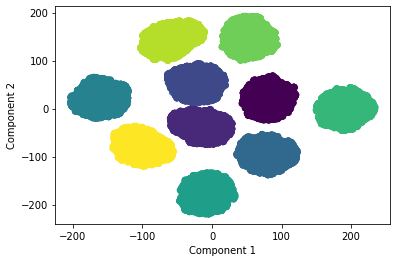

In [8]:
# tsne visualization
from sklearn.manifold import TSNE
from matplotlib import pyplot
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)
ys = np.concatenate(res_dict['y'])
ents = np.concatenate(res_dict['ent'])
x_feats = np.vstack(res_dict['x_feat_wrn402'])

X_res = tsne.fit_transform(x_feats)
np.save('tsne_res.npy', X_res)
pyplot.scatter(X_res[:, 0], X_res[:, 1], c=ys)
# pyplot.scatter(Y_ori[np.logical_or(labels_ori == a, labels_ori == b)][:, 0], Y_ori[np.logical_or(labels_ori == a, labels_ori == b)][:, 1], c=labels_ori[np.logical_or(labels_ori == a, labels_ori == b)]+2)
pyplot.xlabel('Component 1')
pyplot.ylabel('Component 2')
pyplot.plot()

<AxesSubplot:ylabel='Density'>

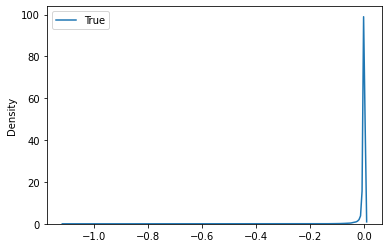

In [9]:
import seaborn as sns
sns.kdeplot(ents, hue=True)

[]

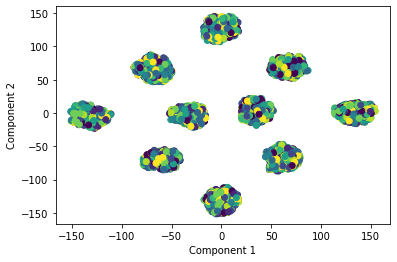

In [10]:
random_idx = np.random.randint(0, len(ys), (5000, ))
ys_simple = ys[random_idx]
ents_simple = ents[random_idx]
x_feats_simple = x_feats[random_idx]

X_res_simple = np.load('tsne_res_simple.npy')
# X_res_simple = tsne.fit_transform(x_feats_simple)
# np.save('tsne_res_simple.npy', X_res_simple)
pyplot.scatter(X_res_simple[:, 0], X_res_simple[:, 1], c=ys_simple)
# pyplot.scatter(Y_ori[np.logical_or(labels_ori == a, labels_ori == b)][:, 0], Y_ori[np.logical_or(labels_ori == a, labels_ori == b)][:, 1], c=labels_ori[np.logical_or(labels_ori == a, labels_ori == b)]+2)
pyplot.xlabel('Component 1')
pyplot.ylabel('Component 2')
pyplot.plot()

In [11]:
## Synthetic Dataset
import os
from registry import NORMALIZE_DICT
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# train_transform = T.Compose([
#             #T.Resize((224, 224), Image.BICUBIC),
#     T.RandomCrop(32, padding=4),
#     T.RandomHorizontalFlip(),
#     T.ToTensor(),
#     T.Normalize( **NORMALIZE_DICT[name] ),
# ])
val_transform = T.Compose([
    #T.Resize((224, 224), Image.BICUBIC),
    T.ToTensor(),
    T.Normalize( **NORMALIZE_DICT[dataset_name] ),
])

class CIFAR100Gen(Dataset):
    def __init__(self, root, transform=None, target_transform=None, return_target=False):
        self.root = root
        self.files = os.listdir(root)
        self.transform = transform
        self.target_transform = target_transform
        self.return_target = return_target
    
    def __getitem__(self, idx):
        f = os.path.join(self.root, self.files[idx])
        

        img = Image.open(f)
        if self.transform is not None:
            img = self.transform(img)
        
        if self.return_target:
            target = int(self.files[idx].split('-')[2])
            if self.target_transform is not None:
                target = self.target_transform(target)
            return img, target, idx
        else:
            return img
    
    def __len__(self):
        return len(self.files)
    
syn_dataset = CIFAR100Gen(root='/data/lijingru/DataFree/run/deepinv/', transform=val_transform)
data_loader = DataLoader(dataset=syn_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
np.save('entropy_real.npy', ents_simple)

200it [00:02, 67.20it/s]
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.686s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.874826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.413727
[t-SNE] KL divergence after 10000 iterations: 1.482687


[]

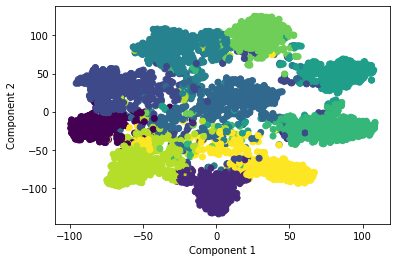

In [12]:
res_dict = {'y':[], 'ent':[], 'x_feat_wrn402':[]}
with torch.no_grad():
    for i, data in tqdm.tqdm(enumerate(data_loader)):
        x = data
        # t_feat for t_sne
        t_out, t_feat = teacher(x.to(gpu), return_features=True)
        neg_entropy = (F.softmax(t_out, 1) * F.log_softmax(t_out, 1)).sum(1)
        res_dict['y'].append(t_out.argmax(1).cpu().numpy())
        res_dict['ent'].append(neg_entropy.cpu().numpy())
        res_dict['x_feat_wrn402'].append(t_feat.cpu().numpy())
        
ys = np.concatenate(res_dict['y'])
ents = np.concatenate(res_dict['ent'])
x_feats = np.vstack(res_dict['x_feat_wrn402'])
        
ys_simple = ys[random_idx]
ents_simple = ents[random_idx]
x_feats_simple = x_feats[random_idx]

X_res_simple = tsne.fit_transform(x_feats_simple)
np.save('tsne_syn_simple.npy', X_res_simple)
np.save('entropy_syn.npy', ents_simple)
pyplot.scatter(X_res_simple[:, 0], X_res_simple[:, 1], c=ys_simple)
# pyplot.scatter(Y_ori[np.logical_or(labels_ori == a, labels_ori == b)][:, 0], Y_ori[np.logical_or(labels_ori == a, labels_ori == b)][:, 1], c=labels_ori[np.logical_or(labels_ori == a, labels_ori == b)]+2)
pyplot.xlabel('Component 1')
pyplot.ylabel('Component 2')
pyplot.plot()

<AxesSubplot:ylabel='Density'>

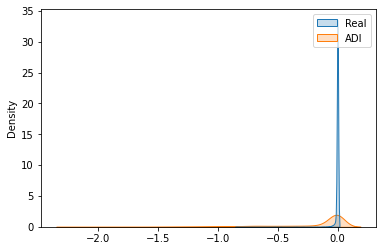

In [22]:
import pandas as pd
ent_simple_real = ents[random_idx]
data = np.hstack([ent_simple_real[:, np.newaxis],  ents_simple[:, np.newaxis]])
data = pd.DataFrame(data, columns=['Real', 'ADI'])
sns.kdeplot(data={'Real': np.load('entropy_real.npy'), 'ADI': ents[random_idx]}, fill=True)